### Experiments conducted with TSM

In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [ ]:



# monthly training vs monthly testing summaries 
def calculate_anomaly_score_monthly(train_profiles, test_profiles, agent):

    alpha= 0.03
    beta=0.2
    gamma= 0.07
    delta= 0.4
    a = 0.3
    b = 0.04
    c = 0.1
    d = 0.5
    e = 0.07

    max_scores = []

    train_profiles = train_profiles[train_profiles["agent"] == agent]
    test_profiles  = test_profiles[test_profiles["agent"] == agent]

    merged = pd.merge(
            test_profiles, 
            train_profiles, 
            on=['day_type', 'time_segment'], 
            suffixes=('_test', '_train'), 
            how='left'
        )

 
    # Fill numeric training columns with 0 if no history exists for that slot - good 
    numeric_cols = ['unique_location_ids_train', 'avg_distance_from_home_km_train', 'avg_speed_kmh_train']
    merged[numeric_cols] = merged[numeric_cols].fillna(0)

    # Calculate Scores

    # Component 1: Count Difference (Absolute)
    score_count = (merged['unique_location_ids_test'] - merged['unique_location_ids_train']).abs()

    # Component 2: Distance Difference (Absolute)
    score_dist = (merged['avg_distance_from_home_km_test'] - merged['avg_distance_from_home_km_train']).abs()

    # Component 3: Speed Difference (Absolute)
    score_speed = (merged['avg_speed_kmh_test'] - merged['avg_speed_kmh_train']).abs()

    # Component 4: New Locations (Set Difference)
    def get_new_loc_count(row):
        # Handle cases where training data is NaN (no history) or not a list
        locs_train = row['unique_locs_train']
        locs_test = row['unique_locs_test']
        
        set_train = set(locs_train) if isinstance(locs_train, list) else set()
        set_test = set(locs_test) if isinstance(locs_test, list) else set()
        
        # Count items in Test that are NOT in Train
        return len(set_test - set_train)

    score_new_locs = merged.apply(get_new_loc_count, axis=1)

    # Component 5: max duration in a staypoint
    max_stay = (merged['max_stay_duration_test'] - merged['max_stay_duration_train']).abs()

    # Component 6: no of staypoint transformations for a day
    transformations = (merged['transformations_test'] - merged['transformations_train']).abs()

    # Component 7: max distance from home
    max_distance = (merged['max_distance_from_home_test'] - merged['max_distance_from_home_train']).abs()

    # Component 8:
    dominent_poi_changed = (merged['dominent_poi_test'] != merged['dominent_poi_train']).astype(int)

    # Component 9:
    def get_new_poi_count(row):
        # Handle cases where training data is NaN (no history) or not a list
        pois_train = row['poi_dict_train']
        pois_test = row['poi_dict_test']
        
        set_train = set(pois_train) if isinstance(pois_train, list) else set()
        set_test = set(pois_test) if isinstance(pois_test, list) else set()
        
        # Count items in Test that are NOT in Train
        return len(set_test - set_train)

    score_pois_locs = merged.apply(get_new_poi_count, axis=1)


    # Weighted Sum
    total_scores = (
        (alpha * score_count) + 
        (beta  * score_dist) +
        (gamma * score_speed) +
        (delta * score_new_locs) + 
        (a * max_stay) +
        (b * transformations) +
        (c * max_distance) + 
        (d * dominent_poi_changed) +
        (e * score_pois_locs)
    )

    max_scores.append(total_scores.max())

    # 6. Return the Maximum Score
    return float(max(max_scores))



# monthly training vs weekly testing
def calculate_anomaly_score_mv(train_profiles, test_profiles, agent):

    alpha= 0.03
    beta=0.2
    gamma= 0.07
    delta= 0.4
    a = 0.3
    b = 0.04
    c = 0.1
    d = 0.5
    e = 0.07

    max_scores = []

    train_profiles = train_profiles[train_profiles["agent"] == agent]
    test_profiles  = test_profiles[test_profiles["agent"] == agent]

    for i in test_profiles.chunk:
        test_profiles_chunk = test_profiles[test_profiles['chunk'] == i]    
        merged = pd.merge(
            test_profiles_chunk, 
            train_profiles, 
            on=['day_type', 'time_segment'], 
            suffixes=('_test', '_train'), 
            how='left'
        )
        
        # Fill numeric training columns with 0 if no history exists for that slot - good 
        numeric_cols = ['unique_location_ids_train', 'avg_distance_from_home_km_train', 'avg_speed_kmh_train']
        merged[numeric_cols] = merged[numeric_cols].fillna(0)

        # Calculate Scores

        # Component 1: Count Difference (Absolute)
        score_count = (merged['unique_location_ids_test'] - merged['unique_location_ids_train']).abs()

        # Component 2: Distance Difference (Absolute)
        score_dist = (merged['avg_distance_from_home_km_test'] - merged['avg_distance_from_home_km_train']).abs()

        # Component 3: Speed Difference (Absolute)
        score_speed = (merged['avg_speed_kmh_test'] - merged['avg_speed_kmh_train']).abs()

        # Component 4: New Locations (Set Difference)
        def get_new_loc_count(row):
            # Handle cases where training data is NaN (no history) or not a list
            locs_train = row['unique_locs_train']
            locs_test = row['unique_locs_test']
            
            set_train = set(locs_train) if isinstance(locs_train, list) else set()
            set_test = set(locs_test) if isinstance(locs_test, list) else set()
            
            # Count items in Test that are NOT in Train
            return len(set_test - set_train)

        score_new_locs = merged.apply(get_new_loc_count, axis=1)

        # Component 5: max duration in a staypoint
        max_stay = (merged['max_stay_duration_test'] - merged['max_stay_duration_train']).abs()

        # Component 6: no of staypoint transformations for a day
        transformations = (merged['transformations_test'] - merged['transformations_train']).abs()

        # Component 7: max distance from home
        max_distance = (merged['max_distance_from_home_test'] - merged['max_distance_from_home_train']).abs()

        # Component 8:
        dominent_poi_changed = (merged['dominent_poi_test'] != merged['dominent_poi_train']).astype(int)

        # Component 9:
        def get_new_poi_count(row):
            # Handle cases where training data is NaN (no history) or not a list
            pois_train = row['poi_dict_train']
            pois_test = row['poi_dict_test']
            
            set_train = set(pois_train) if isinstance(pois_train, list) else set()
            set_test = set(pois_test) if isinstance(pois_test, list) else set()
            
            # Count items in Test that are NOT in Train
            return len(set_test - set_train)

        score_pois_locs = merged.apply(get_new_poi_count, axis=1)


        # Weighted Sum
        total_scores = ( 
            (beta  * score_dist) +
            #(gamma * score_speed) +
            (delta * score_new_locs) + 
            (a * max_stay) +
            (b * transformations) +
            (c * max_distance) + 
            (d * dominent_poi_changed) +
            (e * score_pois_locs)
        )

        max_scores.append(total_scores.max())
    
    # 6. Return the Maximum Score
    return float(max(max_scores))

In [ ]:
train = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/processed/agent_profiles_train_monthly.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/processed/agent_profiles_test_monthly.csv')

print(f"Training profiles: {len(train)} entries for {train['agent'].nunique()} agents")
print(f"Testing profiles: {len(test)} entries for {test['agent'].nunique()} agents")
print(f"\nCommon agents: {len(set(train['agent'].unique()) & set(test['agent'].unique()))}")

ground_truth = pd.read_csv('/Users/chanuka/Desktop/codespaces/neural_reeb/data/trail_4_sim1_fis/anomalous_agent_sim1.csv')
print(f"Ground truth: {len(ground_truth)} anomalous agents")
print(f"Unique agents in ground truth: {ground_truth['agent'].nunique()}")

Training profiles: 95892 entries for 7991 agents
Testing profiles: 95880 entries for 7990 agents

Common agents: 7990
Ground truth: 259 anomalous agents
Unique agents in ground truth: 259


In [ ]:
train[train['agent'] == 216214]

,s_date,e_date,agent,day_type,time_segment,unique_location_ids,avg_distance_from_home_km,avg_speed_kmh,unique_locs,max_stay_duration,transformations,max_distance_from_home,dominent_poi,poi_dict
25272,2024-10-16 00:00:00+09:00,2024-11-15 00:00:00+09:00,216214,weekday,0-5.59,1,0.00,0.00,[0],360.00,1,0.000570,residential,['residential']
25273,2024-10-16 06:00:00+09:00,2024-11-15 08:10:20+09:00,216214,weekday,6-8.59,2,4.03,33.41,[0 1],127.80,2,8.454184,residential,['residential' 'restaurant:workplace']
25274,2024-10-16 09:00:00+09:00,2024-11-15 09:00:00+09:00,216214,weekday,9-13.59,4,7.36,15.78,[ 0 1 6 12],291.40,2,8.454209,restaurant:workplace,['residential' 'restaurant:workplace' 'restaur...
25275,2024-10-16 14:00:00+09:00,2024-11-15 17:16:40+09:00,216214,weekday,14-17.29,9,4.56,35.65,[ 1 2 0 3 4 5 9 13 11],151.82,3,8.454184,restaurant:workplace,['restaurant:workplace' 'workplace' 'residenti...
25276,2024-10-16 17:30:00+09:00,2024-11-15 18:20:00+09:00,216214,weekday,17.30-21.29,10,1.34,13.52,[ 0 3 4 5 7 9 1 10 11 14],215.52,2,8.453916,residential,['residential' 'workplace' 'recreation' 'resta...
25277,2024-10-16 21:30:00+09:00,2024-11-15 21:30:00+09:00,216214,weekday,21.30-23.59,1,0.00,0.00,[0],150.00,1,0.000570,residential,['residential']
25278,2024-10-19 00:00:00+09:00,2024-11-17 00:00:00+09:00,216214,weekend,0-5.59,1,0.00,0.00,[0],360.00,1,0.000429,residential,['residential']
25279,2024-10-19 06:00:00+09:00,2024-11-17 06:00:00+09:00,216214,weekend,6-8.59,2,1.95,16.99,[0 1],162.90,2,8.453973,residential,['residential' 'restaurant:workplace']
25280,2024-10-19 09:00:00+09:00,2024-11-17 09:00:00+09:00,216214,weekend,9-13.59,2,2.54,0.00,[0 1],300.00,1,8.453973,residential,['residential' 'restaurant:workplace']
25281,2024-10-19 14:00:00+09:00,2024-11-17 14:00:00+09:00,216214,weekend,14-17.29,3,1.96,18.08,[0 1 8],190.97,2,8.453973,residential,['residential' 'restaurant:workplace' 'workpla...


In [ ]:
test[test['agent'] == 216214]

,s_date,e_date,agent,day_type,time_segment,unique_location_ids,avg_distance_from_home_km,avg_speed_kmh,unique_locs,max_stay_duration,transformations,max_distance_from_home,dominent_poi,poi_dict
25272,2024-11-18 00:00:00+09:00,2024-12-20 00:00:00+09:00,216214,weekday,0-5.59,1,0.00,0.00,[0],360.00,1,0.000333,residential,['residential']
25273,2024-11-18 06:00:00+09:00,2024-12-20 08:12:40+09:00,216214,weekday,6-8.59,2,4.23,34.33,[0 1],123.37,2,8.453908,residential,['residential' 'restaurant:workplace']
25274,2024-11-18 09:00:00+09:00,2024-12-20 09:00:00+09:00,216214,weekday,9-13.59,3,8.06,10.29,[ 1 3 15],291.61,2,8.453908,restaurant:workplace,['restaurant:workplace' 'restaurant']
25275,2024-11-18 14:00:00+09:00,2024-12-20 16:46:00+09:00,216214,weekday,14-17.29,10,4.62,32.33,[ 1 0 5 6 7 8 2 9 11 12],153.75,3,8.453908,restaurant:workplace,['restaurant:workplace' 'residential' 'recreat...
25276,2024-11-18 17:30:00+09:00,2024-12-20 17:42:00+09:00,216214,weekday,17.30-21.29,10,1.03,13.85,[ 1 2 0 4 5 7 9 11 8 12],224.25,2,8.453470,residential,['restaurant:workplace' 'workplace' 'residenti...
25277,2024-11-18 21:30:00+09:00,2024-12-20 21:30:00+09:00,216214,weekday,21.30-23.59,1,0.00,0.00,[0],149.99,1,0.000333,residential,['residential']
25278,2024-11-23 00:00:00+09:00,2024-12-15 00:00:00+09:00,216214,weekend,0-5.59,1,0.00,0.00,[0],360.00,1,0.000140,residential,['residential']
25279,2024-11-23 06:00:00+09:00,2024-12-15 08:34:10+09:00,216214,weekend,6-8.59,2,0.31,1.36,[ 0 13],175.04,2,2.820219,residential,['residential' 'recreation']
25280,2024-11-23 09:00:00+09:00,2024-12-15 12:47:00+09:00,216214,weekend,9-13.59,7,0.80,6.72,[ 0 6 8 10 12 13 14],193.42,3,2.820219,residential,['residential' 'workplace' 'education:recreati...
25281,2024-11-23 14:00:00+09:00,2024-12-15 15:46:10+09:00,216214,weekend,14-17.29,2,0.31,1.48,[ 0 14],196.73,2,2.777589,residential,['residential' 'recreation:workplace']


In [ ]:
print("Calculating anomaly scores...")

common_agents = set(train['agent'].unique()) & set(test['agent'].unique())
print(f"Calculating scores for {len(common_agents)} agents...")

anomaly_rows = []


def process_agent(agent):
    score = calculate_anomaly_score_monthly(train, test, agent)
    return {"agent": agent, "anomaly_score": score}

# n_jobs=-1 uses all available CPU cores
anomaly_rows = Parallel(n_jobs=-1)(
    delayed(process_agent)(agent) for agent in common_agents
)

anomaly_df = pd.DataFrame(anomaly_rows)
print(f"\nAnomaly scores calculated for {len(anomaly_df)} agents")

anomaly_df = anomaly_df.dropna(subset=['anomaly_score'])

anomaly_df.head(10)

Calculating anomaly scores...
Calculating scores for 7990 agents...


/Users/chanuka/Desktop/codespaces/neural_reeb/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Anomaly scores calculated for 7990 agents


,agent,anomaly_score
0,655362,6.582806
1,458756,5.452614
2,98310,14.145154
3,32779,8.505816
4,294928,8.617179
5,655380,11.426102
6,426005,6.389728
7,589845,9.736820
8,786455,4.343740
9,426014,5.699760


In [ ]:
anomaly_df.to_csv('segment_patterns.csv', index=False)

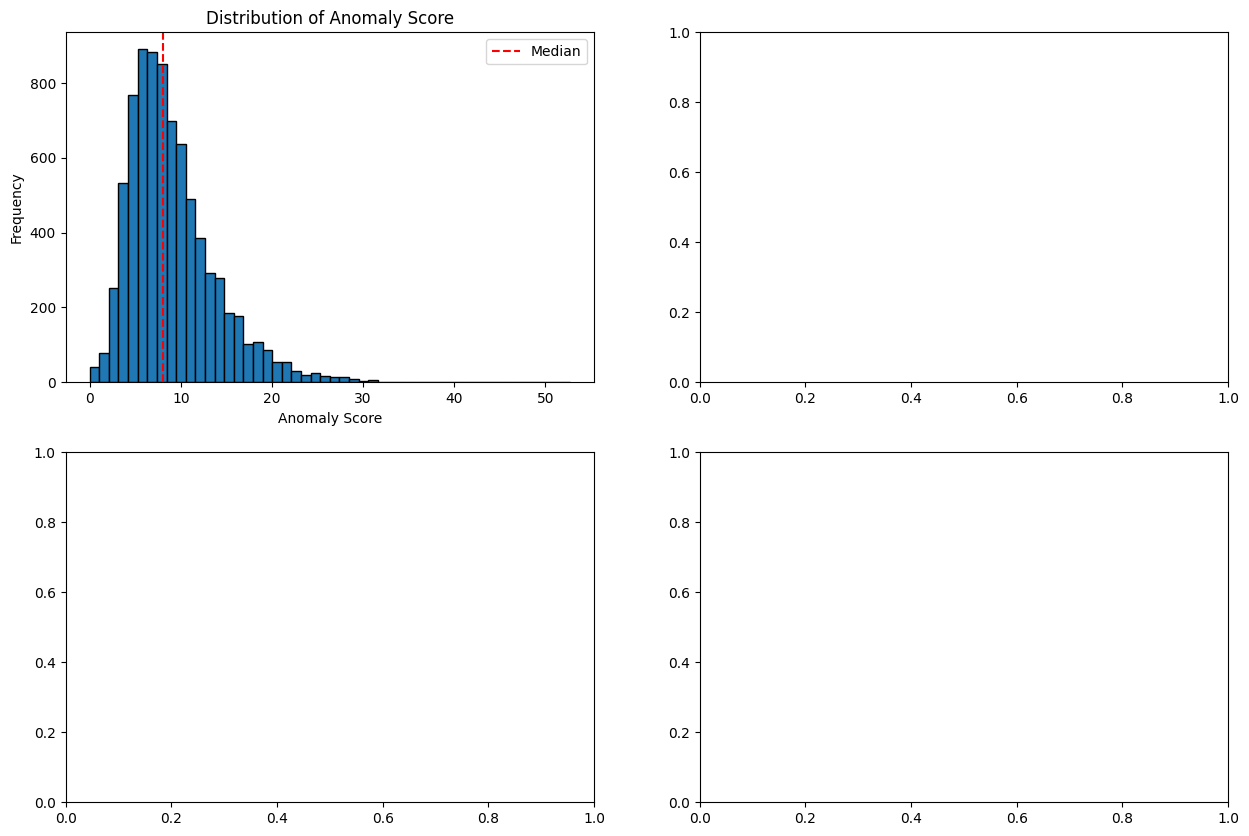

In [ ]:
# Visualize distribution of anomaly scores
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Composite anomaly score
axes[0, 0].hist(anomaly_df['anomaly_score'], bins=50, edgecolor='black')
axes[0, 0].set_title('Distribution of Anomaly Score')
axes[0, 0].set_xlabel('Anomaly Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(anomaly_df['anomaly_score'].median(), color='r', linestyle='--', label='Median')
axes[0, 0].legend()

In [ ]:
# Prepare data for precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Create binary labels: 1 if agent is in ground truth anomalies, 0 otherwise
gt_anomaly_agents = set(ground_truth['agent'].values)
anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)

print(f"Total agents in anomaly_df: {len(anomaly_df)}")
print(f"Anomalous agents (ground truth): {anomaly_df['is_anomaly'].sum()}")
print(f"Normal agents: {(anomaly_df['is_anomaly'] == 0).sum()}")
print(f"\nAnomaly rate: {anomaly_df['is_anomaly'].mean():.4f}")

# Calculate baseline (random classifier performance)
baseline_precision = anomaly_df['is_anomaly'].mean()
print(f"\nBaseline (random classifier) precision: {baseline_precision:.4f}")

Total agents in anomaly_df: 7990
Anomalous agents (ground truth): 241
Normal agents: 7749

Anomaly rate: 0.0302

Baseline (random classifier) precision: 0.0302


In [ ]:
# Calculate precision-recall curves for different anomaly score metrics
score_metrics = {
    'composite_anomaly_score': 'Composite Anomaly Score',
    'sum_normalized_score': 'Sum Normalized Score',
    'euclidean_distance': 'Euclidean Distance',
    'avg_norm_diff_locations': 'Avg Norm Diff Locations',
    'avg_norm_diff_distance': 'Avg Norm Diff Distance',
    'avg_norm_diff_speed': 'Avg Norm Diff Speed',
    'anomaly_score': 'Anomaly Score'
}

# Store results
pr_curves = {}
ap_scores = {}

y_true = anomaly_df['is_anomaly'].values

for metric, label in score_metrics.items():
    if metric in anomaly_df.columns:
        y_scores = anomaly_df[metric].values
        
        # Handle NaN values
        mask = ~np.isnan(y_scores)
        if mask.sum() > 0:
            precision, recall, thresholds = precision_recall_curve(y_true[mask], y_scores[mask])
            ap_score = average_precision_score(y_true[mask], y_scores[mask])
            
            pr_curves[metric] = {
                'precision': precision,
                'recall': recall,
                'thresholds': thresholds,
                'label': label
            }
            ap_scores[metric] = ap_score
            
            print(f"{label}: AP = {ap_score:.4f}")
        else:
            print(f"{label}: No valid scores (all NaN)")
    else:
        print(f"{label}: Column not found in anomaly_df")

Composite Anomaly Score: Column not found in anomaly_df
Sum Normalized Score: Column not found in anomaly_df
Euclidean Distance: Column not found in anomaly_df
Avg Norm Diff Locations: Column not found in anomaly_df
Avg Norm Diff Distance: Column not found in anomaly_df
Avg Norm Diff Speed: Column not found in anomaly_df
Anomaly Score: AP = 0.1523


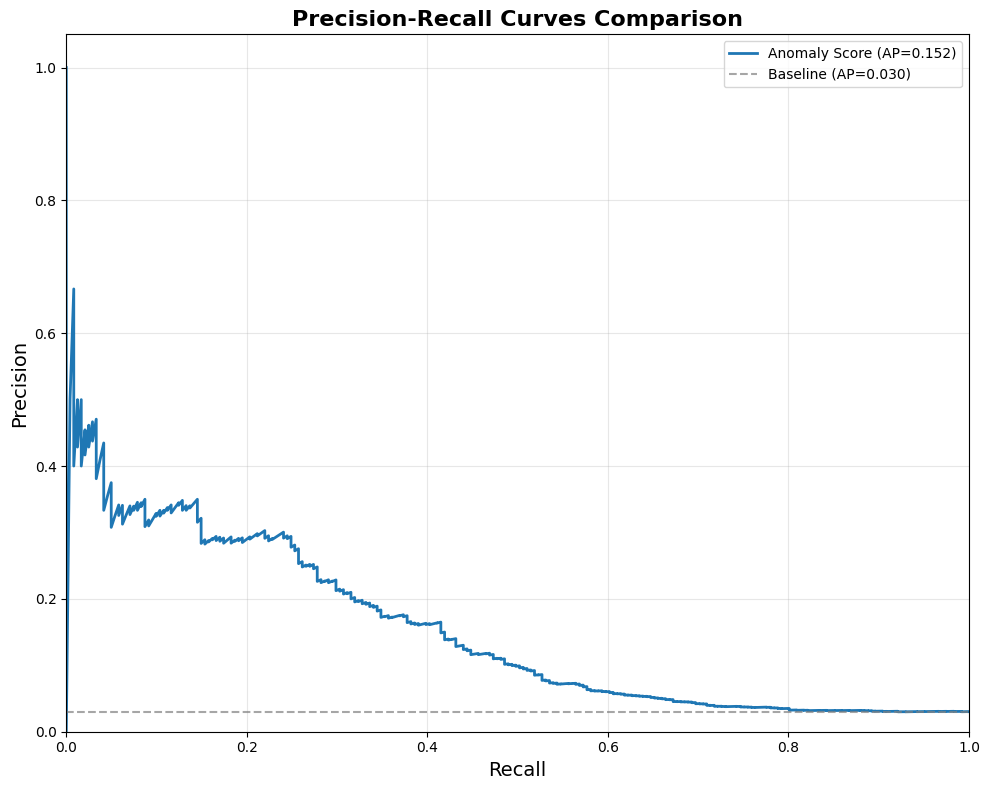

In [ ]:
# Plot all curves on a single graph for comparison
plt.figure(figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, (metric, data) in enumerate(pr_curves.items()):
    precision = data['precision']
    recall = data['recall']
    label = data['label']
    ap_score = ap_scores[metric]
    
    plt.plot(recall, precision, color=colors[idx % len(colors)], 
             linewidth=2, label=f'{label} (AP={ap_score:.3f})')

# Add baseline (random classifier)
plt.axhline(y=baseline_precision, color='gray', linestyle='--', 
            linewidth=1.5, label=f'Baseline (AP={baseline_precision:.3f})', alpha=0.7)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves Comparison', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()


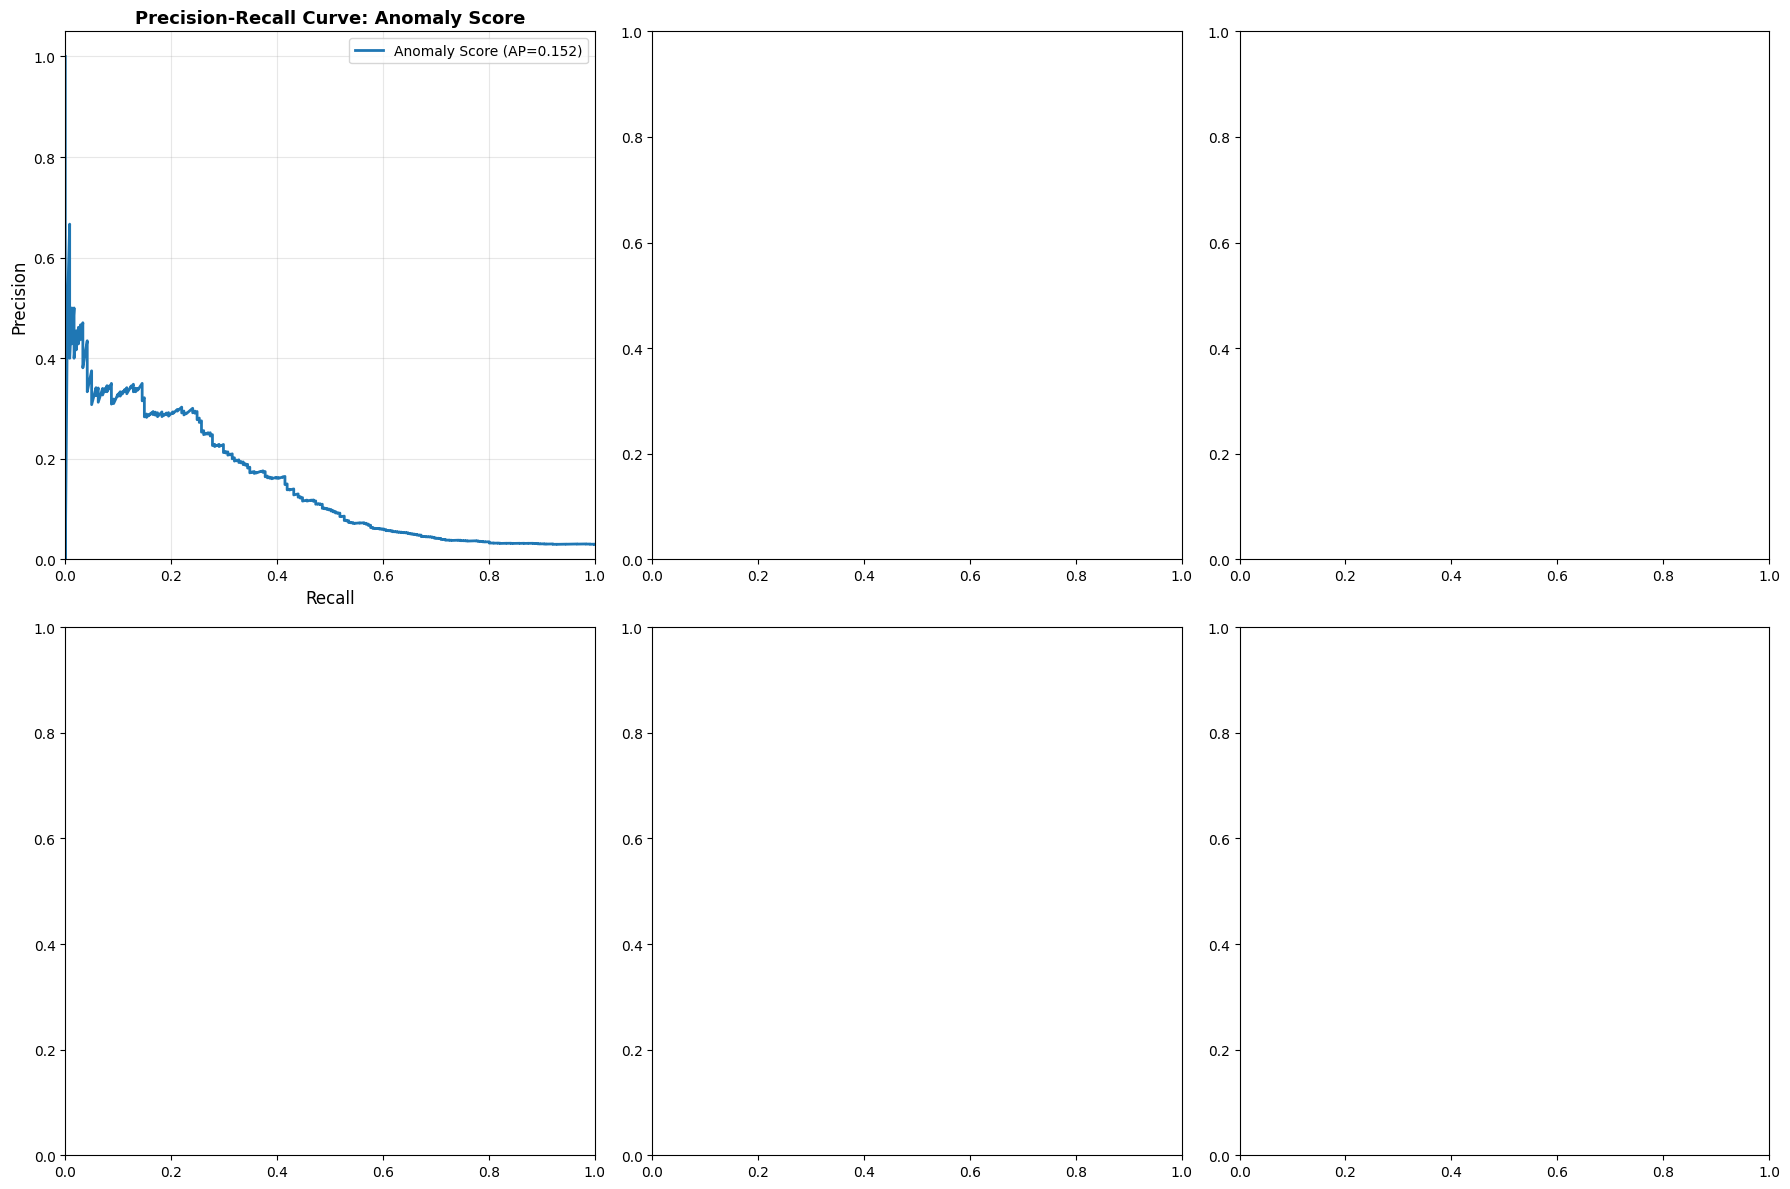

In [ ]:
# Plot precision-recall curves
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, (metric, data) in enumerate(pr_curves.items()):
    ax = axes[idx]
    
    precision = data['precision']
    recall = data['recall']
    label = data['label']
    ap_score = ap_scores[metric]
    
    ax.plot(recall, precision, color=colors[idx % len(colors)], 
            linewidth=2, label=f'{label} (AP={ap_score:.3f})')
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'Precision-Recall Curve: {label}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()


In [ ]:
# Analyze top 10% highest anomaly scores
TOP_FRACTION = 0.10
num_agents = len(anomaly_df)
top_n = max(1, int(np.ceil(num_agents * TOP_FRACTION)))

print(f"Total agents: {num_agents}")
print(f"Selecting top {TOP_FRACTION:.0%} => {top_n} agents with highest composite scores")

# Select top agents by composite anomaly score
anomaly_df_sorted = anomaly_df.sort_values('anomaly_score', ascending=False)
top_agents = anomaly_df_sorted.head(top_n).copy()

# Check how many are in ground truth
top_agents['is_ground_truth'] = top_agents['agent'].isin(gt_anomaly_agents)
num_gt_in_top = top_agents['is_ground_truth'].sum()

print(f"Ground truth anomalies within top {TOP_FRACTION:.0%}: {num_gt_in_top}")
print(f"Percentage of top {TOP_FRACTION:.0%} that are ground truth: {num_gt_in_top / top_n:.2%}")
print(f"Share of all ground truth anomalies captured: {num_gt_in_top / anomaly_df['is_anomaly'].sum():.2%}")

top_agents[['agent', 'anomaly_score', 'is_ground_truth']].head(20)


Total agents: 7990
Selecting top 10% => 799 agents with highest composite scores
Ground truth anomalies within top 10%: 104
Percentage of top 10% that are ground truth: 13.02%
Share of all ground truth anomalies captured: 43.15%


,agent,anomaly_score,is_ground_truth
7450,30458,52.701053,False
3195,569816,38.503147,True
6821,683055,37.893341,True
4841,216214,33.585775,False
3025,405330,33.252943,False
5220,119479,32.426097,True
805,167183,31.615608,False
456,34675,31.469100,True
2039,139306,31.192771,False
5910,712169,30.628429,False


In [1]:
top_agents[top_agents['agent'] == 322561]

NameError: name 'top_agents' is not defined

In [35]:
top_agents

,agent,anomaly_score,is_anomaly,is_ground_truth
7450,30458,52.701053,0,False
3195,569816,38.503147,1,True
6821,683055,37.893341,1,True
4841,216214,33.585775,0,False
3025,405330,33.252943,0,False
...,...,...,...,...
344,394613,15.390661,0,False
14,524331,15.390109,0,False
839,691636,15.387095,0,False
636,527010,15.377999,0,False


In [48]:
# very low anomaly score for this guy 561615
anomaly_df_sorted[anomaly_df_sorted['agent'] == 225613]

,agent,anomaly_score,is_anomaly
7130,225613,4.796163,1
